In [1]:
# IMPORTS AND CONFIGURATIONS

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os
import time
import functools
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import classification_report, confusion_matrix
from joblib import Parallel, delayed
from numba import jit
from pathlib import Path
from dotenv import load_dotenv
from loguru import logger


# Load environment variables from .env file if it exists
load_dotenv()

# Paths
PROJ_ROOT = Path(os.getcwd())
# logger.info(f"PROJ_ROOT path is: {PROJ_ROOT}")

DATA_DIR = PROJ_ROOT

RAW_DATA_DIR = DATA_DIR
INTERIM_DATA_DIR = DATA_DIR
PROCESSED_DATA_DIR = DATA_DIR

MAIN_DATA_FILE_NAME = "dataset_ai_challenge.pkl"

MODELS_DIR = PROJ_ROOT

# Set the font globally to a monospaced font
plt.rcParams['font.family'] = 'monospace'
plt.rcParams['font.monospace'] = ['Courier New', 'Consolas', 'DejaVu Sans Mono']

# If tqdm is installed, configure loguru with tqdm.write
# https://github.com/Delgan/loguru/issues/135
try:
    from tqdm import tqdm

    logger.remove(0)
    logger.add(lambda msg: tqdm.write(msg, end=""), colorize=True)
except ModuleNotFoundError:
    pass

In [2]:
# UTILITY CODE

def load_df(file_path: Path = PROCESSED_DATA_DIR / MAIN_DATA_FILE_NAME) -> pd.DataFrame:
    """Load the dataframe from a pickle file."""
    df = pd.read_pickle(file_path)
    return df


def save_df(df: pd.DataFrame, file_path: Path = PROCESSED_DATA_DIR / MAIN_DATA_FILE_NAME):
    """Save the dataframe to a pickle file."""
    pd.to_pickle(df, file_path)


def load_model(file_name: str, folder=None):
    """Load a model from a pickle file."""
    file_name_ext = file_name + ".pkl"
    dir_path = MODELS_DIR

    if folder is not None:
        dir_path /= folder

    file_path = dir_path / file_name_ext

    with open(file_path, "rb") as file:
        model = pickle.load(file)
    return model


def save_model(model, file_name: str, folder=None):
    """Save a model to a pickle file."""
    file_name_ext = file_name + ".pkl"
    dir_path = MODELS_DIR

    if folder is not None:
        dir_path /= folder
        if not os.path.exists(dir_path):
            os.mkdir(dir_path)

    file_path = dir_path / file_name_ext

    with open(file_path, "wb") as file:
        pickle.dump(model, file)

def time_func(func):
    """Print the execution time of a function."""
    @functools.wraps(func)
    def wrapper(*args, **kwargs):
        start_time = time.perf_counter()  # High-resolution start time
        result = func(*args, **kwargs)  # Execute the function
        end_time = time.perf_counter()  # High-resolution end time
        execution_time = end_time - start_time  # Calculate the execution time
        print(f"Function '{func.__name__}' executed in {execution_time:.8f} seconds")
        return result  # Return the result of the function
    return wrapper


def print_cond(msg, cond):
    """Print the message if the condition is true."""
    if cond:
        print(msg)


def get_submatrix(matrix, row_start=None, row_end=None, col_start=None, col_end=None, auto_flat=False):
    """Get a submatrix from a 2D nested list, handling empty slice arguments."""
    # Autofill omitted values
    if row_start is None:
        row_start = 0
    if row_end is None:
        row_end = len(matrix)
    if col_start is None:
        col_start = 0
    if col_end is None:
        col_end = len(matrix[0])

    # If the matrix becomes a shape of (n, 1) or (1, n), flatten it to be (n) or (1)
    if auto_flat:
        # Check if only 1 row is selected
        if row_end - row_start == 1:
            # Check if only 1 column is selected
            if col_end - col_start == 1:
                # Only 1 item, since 1 row and 1 column
                return matrix[row_start][col_start]
            else:
                # Subset of the selected row
                return [row[col_start:col_end] for row in matrix[row_start]]
        # Check if only 1 column is selected
        elif col_end - col_start == 1:
            # Subset of the selected column
            return [row[col_start] for row in matrix[row_start:row_end]]

    # Default behaviour
    return [row[col_start:col_end] for row in matrix[row_start:row_end]]


def transpose_matrix(matrix):
    """Get the transpose of a 2D nested list."""
    out = [[] for _ in range(len(matrix[0]))]
    for i in range(len(matrix)):
        for j in range(len(matrix[i])):
            out[j].append(matrix[i][j])
    return out


def recast_pred(pred: np.ndarray):
    """Recast the predictions into a series object."""
    return pd.Series(pred, dtype=bool, name="pred")


def flatten_ptu(df: pd.DataFrame):
    """Flatten the PTU for metrics."""
    # Predefined possible operations
    base_agg_dict = {
        "target_two_sided_ptu": "any",
        "target_two_sided_ptu_alt": "any",
        "target_two_sided_ptu_realtime": "any",
        "target_two_sided_ptu_flip": "any",
        "pred": "any"
    }

    # Possible operations given the input
    agg_dict = {}
    for column in df.columns:
        if column in base_agg_dict:
            agg_dict[column] = base_agg_dict[column]

    if len(agg_dict) == 0:
        raise ValueError("Given DataFrame has no columns to flatten.")

    # Flatten
    flat_df = df.groupby("ptu_id").agg(agg_dict).reset_index()
    return flat_df


def lag(df: pd.DataFrame, feature: str, amount=1):
    """Lag a feature by an amount."""
    lagged_feature = f"{feature}_{amount}"
    df[lagged_feature] = df[feature].shift(amount)
    return df


def to_category(df: pd.DataFrame, feature: str):
    """Convert a feature in the dataframe to type `category`"""
    df[feature] = df[feature].astype("category")
    return df


def to_bool(df: pd.DataFrame, feature: str):
    """Convert a feature in the dataframe to type `bool`"""
    df[feature] = df[feature].astype(bool)
    return df


def recast_categorical(df: pd.DataFrame, to_cat=True):
    """Recast categorical features from type 'bool' to `category` or vice versa."""
    features = [
        "naive_strategy_action",
        "workday",
        "is_balanced"
    ]

    # Apply the corresponding function
    func = to_category if to_cat else to_bool
    for feature in features:
        df = func(df, feature)
    return df

@jit
def change_after_flip(target, value, flips=1):
    """Change the values after flipping."""
    length = len(target)
    for i in range(0, length, 15):
        flip_count = 0
        end = min(i + 15, length)
        for idx in range(i, end):
            if target[idx]:
                flip_count += 1
                if flip_count >= flips:
                    target[idx + 1:end] = value
    return target


def detect_flip(target: pd.Series):
    """Sets the flipping point to True, the rest to False. Works best with adjusted target."""
    return pd.Series(change_after_flip(target.to_numpy(copy=True), False), name="flip")


def adjust_pred_consistency(pred: pd.Series, flips=3):
    """
    Adjust the predictions to be consistent.\\
    If it predicts True earlier, it will keep being True for the rest of the PTU.
    """
    return pd.Series(change_after_flip(pred.to_numpy(copy=True), True, flips), name="pred")


def adjust_pred_realtime(realtime: pd.Series, pred: pd.Series):
    """
    Adjust the predictions to be at least as good as realtime.
    It will merge the predictions and the realtime target.
    """
    return realtime | pred


def adjust_pred_conform(pred: pd.Series):
    """Set the first values in each PTU to be false to correspond to the original target."""
    @jit
    def set_first_two_false(pred):
        for i in range(0, len(pred), 15):
            pred[i] = False
            pred[i + 1] = False
        return pred
    return pd.Series(set_first_two_false(pred.to_numpy(copy=True)), name="pred")

In [3]:
# FEATURE GENERATAION CODE

def add_ids(df: pd.DataFrame):
    """Adds a column containing an unique id for each ptu."""
    df["ptu_id"] = (df["datetime"] - df["datetime"].min()) // pd.Timedelta(minutes=15)

    logger.info("Added id for each ptu. (ptu_id)")

    df["fix_ptu_id"] = df["ptu_id"].shift(2, fill_value=-1)

    logger.info("Added id for each ptu with delay. (fix_ptu_id)")
    return df


def add_alt_target(df: pd.DataFrame, version="target"):
    """Adds a column containing an alternative target, the first two minutes are also counted."""
    df[f"{version}_two_sided_ptu_alt"] = df.groupby("fix_ptu_id")[f"{version}_two_sided_ptu"].transform("any")

    logger.info(f"Added alternative target. ({version}_two_sided_ptu_alt)")
    return df


def add_realtime_target(df: pd.DataFrame, version="target"):
    """Adds a column containing a real-time version of the target."""
    df[f"{version}_two_sided_ptu_realtime"] = (df["time_since_last_two_sided"] == 0) & df[f"{version}_two_sided_ptu_alt"]

    logger.info(f"Added realtime target. ({version}_two_sided_ptu_realtime)")
    return df


def add_flip_target(df: pd.DataFrame, version="target"):
    """Adds a column containing when the ptu flipped to two-sided."""
    df[f"{version}_two_sided_ptu_flip"] = detect_flip(df[f"{version}_two_sided_ptu_realtime"])

    logger.info(f"Added flip target. ({version}_two_sided_ptu_flip)")
    return df


def add_fix_target(df: pd.DataFrame, output="fix"):
    """Adds a column containing the fixed version of the target."""
    def set_first_two_false(group):
        group.iloc[:] = group.any()
        group.iloc[:2] = False
        return group

    # Use time since last two sided ptu to create the fixed target
    df[f"{output}_two_sided_ptu"] = df["time_since_last_two_sided"] == 0
    df[f"{output}_two_sided_ptu"] = df.groupby("ptu_id")[f"{output}_two_sided_ptu"].transform(set_first_two_false)

    logger.info(f"Added fix target. ({output}_two_sided_ptu)")
    return df


def add_fix_features(df: pd.DataFrame):
    """Adds multiple columns containing the fixed version of features."""
    def set_first_two_false(group):
        group.iloc[:2] = False
        return group

    transform_dict = {
        "fix_min_ptu_price_known": ["min_price_published", "cummin"],
        "fix_max_ptu_price_known": ["max_price_published", "cummax"],
    }
    # Fix min and max price known
    for fixed, [feature, operation] in transform_dict.items():
        df[fixed] = df.groupby("fix_ptu_id")[feature].transform(operation)
        df[fixed] = df.groupby("fix_ptu_id")[fixed].ffill()

    # Create the best guess using the fixed min and max price known
    df["fix_settlement_price_bestguess"] = df["fix_min_ptu_price_known"]
    mask = df["fix_max_ptu_price_known"].notna()
    df.loc[mask, "fix_settlement_price_bestguess"] = df.loc[mask, "fix_max_ptu_price_known"]

    # Add the alternative version of the fixed bestguess
    df = add_bestguess_alt(df, "fix_")

    # Create the fixed realized by taking the last value of the best guess
    df["fix_settlement_price_realized"] = df.groupby("fix_ptu_id")["fix_settlement_price_bestguess_alt"].transform("last")

    # Create the fixed versions of the targets using the new fixed features
    # Since "fix" version already existed before, this will receive "fix2"
    # "fix2" is not better than "fix", but is usefull for other feature creation
    df["fix2_two_sided_ptu_realtime"] = mask & df["fix_min_ptu_price_known"].notna()
    df["fix2_two_sided_ptu_alt"] = df.groupby("fix_ptu_id")["fix_two_sided_ptu_realtime"].transform("any")
    df["fix2_two_sided_ptu"] = df.groupby("fix_ptu_id")["fix_two_sided_ptu_alt"].transform(set_first_two_false)

    logger.info("Added several fixed features. (<many>)")
    return df


def add_binary_features(df: pd.DataFrame):
    """Adds a column containing binary features."""
    # The electricity is balanced if both min and max price are NaN
    df["is_balanced"] = df["min_price_published"].isna() & df["max_price_published"].isna()

    # The min price is currently negative
    df["down_negative"] = df["min_price_published"] < 0

    logger.info("Added binary features. (<many>)")
    return df


def add_time_since(df: pd.DataFrame, base="target", output=""):
    """Adds a column containing the time since last two sided ptu."""
    @jit
    def count_after(realtime: np.ndarray):
        """Counts the time after a two sided ptu."""
        out = np.empty_like(realtime, dtype=np.float_)
        count = 0
        add = 1 / 15  # time_since_last_two_sided counts is not in minutes but in PTUs
        for i in range(len(realtime)):
            # Is it currently a two sided ptu
            if realtime[i]:
                count = 0
            else:
                count += add
            out[i] = count
        return out

    df[f"{output}time_since_last_two_sided_alt"] = count_after(df[f"{base}_two_sided_ptu_realtime"].to_numpy())

    logger.info(f"Added alternative best guess. ({output}time_since_last_two_sided_alt)")
    return df


def add_bestguess_alt(df: pd.DataFrame, version=""):
    """Adds a column containing an alternative best guess by filling NaNs with mid price."""
    df[f"{version}settlement_price_bestguess_alt"] = df[f"{version}settlement_price_bestguess"]

    # Fill the NaN with mid price
    mask = df[f"{version}settlement_price_bestguess"].isna()
    df.loc[mask, f"{version}settlement_price_bestguess_alt"] = df.loc[mask, "mid_price_published"]

    logger.info(f"Added alternative best guess. ({version}settlement_price_bestguess_alt)")
    return df


def add_started_down(df: pd.DataFrame):
    """Adds a column containing if the ptu started with a down price."""
    df["started_down"] = df["min_price_published"].notna()
    df["started_down"] = df.groupby("fix_ptu_id")["started_down"].transform("first")

    logger.info("Added indicator for start on down. (started_down)")
    return df


def add_residual_load(df: pd.DataFrame):
    """Adds a column containing the residual load."""
    df["residual_load"] = df["forecast_demand"] - df["forecast_solar"] - df["forecast_wind"]

    logger.info("Added residual load. (residual_load)")
    return df


def add_forecast_deltas(df: pd.DataFrame):
    """Adds multiple columns containing the deltas of the forecasts."""
    df["forecast_wind_delta"] = df["forecast_wind"].diff(15)
    df["forecast_solar_delta"] = df["forecast_solar"].diff(15)
    df["forecast_demand_delta"] = df["forecast_demand"].diff(15)

    logger.info("Added deltas of forecasts. (<many>)")
    return df


def add_price_volume(df: pd.DataFrame):
    """Adds multiple columns containing price volume features."""
    df["down_price_volume"] = df["downward_dispatch_published"] * df["min_price_published"]
    df["up_price_volume"] = df["upward_dispatch_published"] * df["max_price_published"]
    df["diff_price_volume"] = df["up_price_volume"] - df["down_price_volume"]

    logger.info("Added price volume features. (<many>)")
    return df


def add_eneco_features(df: pd.DataFrame):
    """Adds multiple columns containing features from Eneco."""
    df["max_price_filled_known"] = df["max_ptu_price_known"]
    mask = df["max_ptu_price_known"].isna()
    df.loc[mask, "max_price_filled_known"] = df.loc[mask, "mid_price_published"]
    df["last_15min_up_volume"] = df["upward_dispatch_published"].rolling(15, 1).sum()
    df["last_15min_down_volume"] = df["downward_dispatch_published"].rolling(15, 1).sum()

    logger.info("Added Eneco features. (<many>)")
    return df


def add_diff_features(df: pd.DataFrame):
    """Adds multiple columns containing differences of related columns."""
    df["dispatch_diff"] = df["upward_dispatch_published"] - df["downward_dispatch_published"]
    df["igcc_diff"] = df["igcc_contribution_up_published"] - df["igcc_contribution_down_published"]

    logger.info("Added difference of related columns. (<many>)")
    return df


def add_time_features(df: pd.DataFrame):
    """Adds multiple columns containing time related features."""
    df["month"] = df["datetime"].dt.month
    df["day"] = df["datetime"].dt.day
    df["hour"] = df["datetime"].dt.hour
    df["minute"] = df["datetime"].dt.minute
    df["weekday"] = df["datetime"].dt.weekday
    df["weekday_ptu"] = df["weekday"] * 96 + df["PTU"]
    df["weekday_hour"] = df["weekday"] * 24 + df["hour"]
    df["workday"] = df["weekday"].isin(range(5))

    logger.info("Added several time features. (<many>)")
    return df


def add_peak_features(df: pd.DataFrame):
    """Adds multiple columns containing peak features."""
    def peak_features(df: pd.DataFrame, feature: str, negative=False):
        """Create the peak features."""
        shifted_1 = df[feature].shift(1)
        shifted_2 = df[feature].shift(2)
        if negative:
            df[f"{feature}_peak"] = (df[feature] >= shifted_1) & (shifted_1 < shifted_2)
        else:
            df[f"{feature}_peak"] = (df[feature] <= shifted_1) & (shifted_1 > shifted_2)

        df[f"{feature}_peak_time"] = df[f"{feature}_peak"].cumsum()
        df[f"{feature}_peak_time"] = df.groupby(f"{feature}_peak_time").cumcount() + 1

        peak_values = pd.Series(np.where(df[f"{feature}_peak"], df[feature].shift(1), np.nan)).ffill()
        df[f"{feature}_peak_diff"] = df[feature] - peak_values

        return df

    features = {
        "downward_dispatch_published": [],
        "upward_dispatch_published": [],
        "igcc_contribution_down_published": [],
        "igcc_contribution_up_published": [],
        "min_price_published": [True],
        "max_price_published": [],
    }

    for feature, args in features.items():
        df = peak_features(df, feature, *args)

    logger.info("Added several peak features. (<many>)")
    return df


def add_lagged_features(df: pd.DataFrame):
    """Adds multiple columns containing lagged features."""
    features = {
        "min_price_published": [1],
        "max_price_published": [1],
        "fix_two_sided_ptu": [17],
        "settlement_price_realized": [17],
        "minute_in_ptu": [2]
    }
    for feature, amounts in features.items():
        for amount in amounts:
            df = lag(df, feature, amount)

    logger.info("Added several lagged features. (<many>)")
    return df


def generate_features(
    input_path: Path = INTERIM_DATA_DIR / MAIN_DATA_FILE_NAME,
    output_path: Path = PROCESSED_DATA_DIR / MAIN_DATA_FILE_NAME,
):
    logger.info("Loading dataset and initializing operations...")
    df = load_df(input_path)

    # List of (feature_function, args, kwargs) tuples
    tasks = [
        (add_ids, (), {}),
        (add_alt_target, (), {}),
        (add_realtime_target, (), {}),
        (add_flip_target, (), {}),
        (add_fix_target, (), {}),
        (add_alt_target, (), {"version": "fix"}),
        (add_realtime_target, (), {"version": "fix"}),
        (add_flip_target, (), {"version": "fix"}),
        (add_fix_features, (), {}),
        (add_binary_features, (), {}),
        (add_time_since, (), {"base": "fix2"}),
        (add_bestguess_alt, (), {}),
        (add_started_down, (), {}),
        (add_residual_load, (), {}),
        (add_forecast_deltas, (), {}),
        (add_price_volume, (), {}),
        (add_eneco_features, (), {}),
        (add_diff_features, (), {}),
        (add_time_features, (), {}),
        (add_peak_features, (), {}),
        (add_lagged_features, (), {})
    ]

    logger.info("Generating features from dataset...")
    for func, args, kwargs in tqdm(tasks, desc="Generating features"):
        df = func(df, *args, **kwargs)

    df = save_df(df, output_path)
    logger.success("Features generation complete.")

In [4]:
# DATA PREPROCESSING

def fix_target(df: pd.DataFrame) -> pd.DataFrame:
    """Fix the target to be more correct and consistent. (NOTE this will replace the default)"""
    temp_df = pd.concat([df["datetime"], df["time_since_last_two_sided"]], axis=1)
    temp_df.columns = ["datetime", "time_since_last_two_sided"]
    temp_df = add_ids(temp_df)
    temp_df = add_realtime_target(temp_df)
    temp_df = add_fix_target(temp_df)
    df["target_two_sided_ptu"] = temp_df["fix_two_sided_ptu_realtime"]

    logger.info("Fixed the target.")
    return df


def fix_nan(df: pd.DataFrame):
    """Forward fills some features to fix NaNs."""
    features = [
        "upward_dispatch_published",
        "downward_dispatch_published",
        "igcc_contribution_up_published",
        "igcc_contribution_down_published",
        "forecast_wind",
        "forecast_solar",
        "forecast_demand",
    ]
    df[features] = df[features].ffill()

    logger.info("Fixed all the NaNs in some features.")
    return df


def process_data(
    input_path: Path = RAW_DATA_DIR / MAIN_DATA_FILE_NAME,
    output_path: Path = INTERIM_DATA_DIR / MAIN_DATA_FILE_NAME,
):
    logger.info("Loading dataset and initializing operations...")
    df = load_df(input_path)

    # List of (feature_function, args, kwargs) tuples
    tasks = [
        (fix_nan, (), {}),
    ]

    logger.info("Processing dataset...")
    for func, args, kwargs in tqdm(tasks, desc="Processing data"):
        df = func(df, *args, **kwargs)

    df = save_df(df, output_path)
    logger.success("Processing dataset complete.")

In [5]:
# DATA SPLITTING

# Standard percentage of data to be used for training, validating and testing
VALID_PERCENTAGE = 0.25
TEST_PERCENTAGE = 0.25

# Default target
TARGET = "target_two_sided_ptu"

# Default features
FEATURES = [

]


def get_splits(
    df: pd.DataFrame,
    features: list[str] = FEATURES,
    target=TARGET,
    valid_percentage=VALID_PERCENTAGE,
    test_percentage=TEST_PERCENTAGE,
    return_dict=True,
    return_dict_pair=True,
) -> dict[list] | list[list]:
    """
    Split the data into training, validation and test sets for a single target variable.

    Returns:
        dict: A dictionary containing training, validation and test sets for features and targets.
    """
    df = df.copy()

    # Test set
    test_date = get_split_date(df, 1 - test_percentage)
    train_valid, test = split_on_date(df, test_date)

    # Training and validation set
    valid_date = get_split_date(train_valid, 1 - valid_percentage)
    train, valid = split_on_date(train_valid, valid_date)

    # Get the pairs for each set
    splits = {
        "train": split_into_pair(train, features, target, return_dict_pair),
        "valid": split_into_pair(valid, features, target, return_dict_pair),
        "test": split_into_pair(test, features, target, return_dict_pair),
        "train_valid": split_into_pair(train_valid, features, target, return_dict_pair),
        "full": split_into_pair(df, features, target, return_dict_pair),
    }

    if return_dict:
        return splits

    return list(splits.values())


def get_split_date(df: pd.DataFrame, split_percentage: float):
    """Calculate the split date using the percentage, rounded to the nearest day."""
    idx = np.round((len(df["datetime"]) * split_percentage))
    date = df.loc[idx, "datetime"].round("D")
    return date


def split_on_date(df: pd.DataFrame, split_date: str):
    """Split the data using the split date."""
    split_date = pd.to_datetime(split_date)
    first = df[df["datetime"] < split_date].reset_index(drop=True)
    second = df[df["datetime"] >= split_date].reset_index(drop=True)
    return [first, second]


def split_into_pair(df: pd.DataFrame, features: list[str], target: str, return_dict=True):
    """Split the data into pairs of input features and output targets."""
    in_pair = df[features].reset_index(drop=True)
    out_pair = df[target].reset_index(drop=True)
    id_pair = df["ptu_id"].reset_index(drop=True)
    df_pair = df.reset_index(drop=True)

    if return_dict:
        return {"in": in_pair, "out": out_pair, "id": id_pair, "df": df_pair}

    return [in_pair, out_pair, id_pair, df_pair]

In [6]:
# VISUALIZATIONS

def default_titles(results, titles):
    """Generate default titles if needed."""
    if titles is None:
        titles = list(range(len(results)))
    return titles


def make_subplots(subplot_func, results, titles, suptitle, figsize):
    """Make subplots using results."""
    # Check if there are multiple results
    if isinstance(results[0], (tuple, list, pd.DataFrame)) and isinstance(results, (tuple, list)):
        single = False
    else:
        single = True
        results = [results]

    # Create subplots
    fig, axes = plt.subplots(1, len(results), figsize=figsize)

    if single:
        axes = [axes]

    # Plot each subplot
    for result, title, ax in zip(results, titles, axes):
        subplot_func(result, title, ax)

    show_subplots(fig, suptitle)


def show_subplots(fig, title):
    """Show the subplots."""
    fig.suptitle(title, fontsize=14)
    plt.tight_layout()
    plt.show()


def plot_df(df, title, ax, text=None):
    """Custom table plot for a small df."""
    ax.axis("tight")
    ax.axis("off")
    df = df.map(lambda x: f"{np.round(x, 2):.2f}")
    table = ax.table(cellText=df.values, colLabels=df.columns, rowLabels=df.index, loc="center")
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.1, 1.3)
    ax.set_title(title)

    if text is not None:
        # Add additional text below the table
        ax.text(0.5, 0.2, text, ha='center', va='top', transform=ax.transAxes, fontsize=12)


def plot_classification_report(report, title, ax):
    """Custom plot for a classification report."""
    classes = list(report.keys())
    metrics = ["precision", "recall", "f1-score", "support"]

    data = []
    for cls in classes:
        row = []
        if isinstance(report[cls], dict):
            for metric in metrics:
                row.append(report[cls].get(metric, ""))
        else:  # for "accuracy"
            row = [report[cls]] * 4
        data.append(row)

    df = pd.DataFrame(data, columns=metrics, index=classes)
    plot_df(df, title, ax)


def plot_confusion_matrix(cm, title, ax):
    """Plot a confusion matrix."""
    index_names = ["False", "True"]
    column_names = ["False", "True"]
    data = cm
    df = pd.DataFrame(data, columns=column_names, index=index_names)
    plot_df(df, title, ax)


def plot_penalty_score(score, title, ax):
    """Plot penalty score."""
    index_names = ["False neg", "False pos", "Total"]
    column_names = ["Percentage", "Prediction", "Maximum"]
    data = score.values
    df = pd.DataFrame(data, columns=column_names, index=index_names)
    plot_df(df, title, ax, "0 is no penalty, 1 is max penalty")


def plot_income_score(score, title, ax):
    """Plot income score."""
    index_names = ["Pred", "Max"]
    column_names = ["Naive", "Model", "Added", "Added %"]
    data = score.values
    df = pd.DataFrame(data, columns=column_names, index=index_names)
    plot_df(df, title, ax, f"Added % of max: {score.iloc[0, 3] / score.iloc[1, 3]:.3f}")


def plot_time_diff_df(score, title, ax):
    """Plot time difference score."""
    index_names = score.index
    column_names = score.columns
    data = score.values
    df = pd.DataFrame(data, columns=column_names, index=index_names)
    plot_df(df, title, ax)


def plot_time_diff_avg(score, title, ax):
    """Plot time difference score."""
    index_names = ["Time delay", "True pos count"]
    column_names = ["Pred", "Max"]
    data = score.values
    df = pd.DataFrame(data, columns=column_names, index=index_names)
    plot_df(df, title, ax, "More neg is better")


ORDER = ['true', 'pred']


def add_show_arg(show_default=False):
    """Decorator to add a plot show arg"""
    def decorator(func):
        def wrapper(*args, **kwargs):
            show = kwargs.pop('show', show_default)

            result = func(*args, **kwargs)

            if show:
                show_graph()

            return result
        return wrapper
    return decorator


def add_ids_arg(ids_default=None):
    """Decorator to add an arg to use job ids"""
    def decorator(func):
        def wrapper(*args, **kwargs):
            ids = kwargs.pop('ids', ids_default)

            result = func(*args, **kwargs)

            if ids is not None:
                add_id_lines(ids)

            return result
        return wrapper
    return decorator


def show_graph():
    """Show the graphs and reorder graphs"""
    plt.gcf().set_size_inches(20, 8)
    change_order()
    plt.show()


def change_order(order=ORDER):
    """Reorder the graphs"""
    handles, labels = plt.gca().get_legend_handles_labels()

    front = 0
    for label in order:
        try:
            index = labels.index(label)
        except ValueError:
            continue

        labels.insert(front, labels.pop(index))
        handles.insert(front, handles.pop(index))
        front += 1

    plt.legend(handles, labels)


def increment_color_cycle():
    """Increment the default color cycle of matplotlib"""
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    new_colors = colors[1:] + colors[:1]
    plt.rcParams['axes.prop_cycle'] = plt.cycler('color', new_colors)


def add_id_lines(ids: pd.Series):
    """Add the job id lines"""
    for index in ids.drop_duplicates(keep='first').index:
        plt.axvline(x=index, color='r', linestyle='--')
        plt.text(index, plt.ylim()[1], f'Job ID: {ids[index]}', rotation=90, verticalalignment='bottom')


@add_show_arg(True)
@add_ids_arg()
def plot_against_index(feature: pd.Series):
    """Plot a feature against the index"""
    plt.plot(feature, label=feature.name)


@add_show_arg(True)
def plot_scatter(feature_x: pd.Series, feature_y: pd.Series):
    """Plot two features in a scatter plot"""
    plt.scatter(feature_x, feature_y)
    plt.xlabel(feature_x.name)
    plt.ylabel(feature_y.name)

In [7]:
# METRICS AND EVALUATIONS

def compute_basic_metrics(df: pd.DataFrame, pred: pd.Series, flatten=True, version="target"):
    """Computes the basic metric performance: classification report and confusion matrix."""
    true = df[f"{version}_two_sided_ptu"]

    if flatten:
        # Concatenate the true, pred, and ids into a single DataFrame
        base = pd.concat([df[f"{version}_two_sided_ptu"], pred, df["ptu_id"]], axis=1)
        base.columns = [f"{version}_two_sided_ptu", "pred", "ptu_id"]
        base = flatten_ptu(base)
        true = base[f"{version}_two_sided_ptu"]
        pred = base["pred"]

    report = classification_report(true, pred, output_dict=True)
    matrix = confusion_matrix(true, pred)
    return report, matrix, flatten


def print_basic_metrics(results, titles=None):
    """Print the basic metrics."""
    titles = default_titles(results, titles)

    # Check if there are multiple results
    try:
        flat = results[0][2]
    except KeyError:
        flat = results[2]

    # Create subplots for classification reports
    make_subplots(
        lambda result, title, ax: plot_classification_report(result[0], title, ax),
        results,
        titles,
        suptitle=f"Comparison of Classification Reports - {"Flattened per PTU" if flat else "Default"}",
        figsize=(18, 2.5)
    )

    # Create subplots for confusion matrices
    make_subplots(
        lambda result, title, ax: plot_confusion_matrix(result[1], title, ax),
        results,
        titles,
        suptitle=f"Comparison of Confusion Matrices - {"Flattened per PTU" if flat else "Default"}",
        figsize=(18, 2)
    )


def show_basic_metrics(df: pd.DataFrame, pred: pd.Series, flatten=True, version="target"):
    """Show basic metric performance, classification report and confusion matrix."""
    results = compute_basic_metrics(df, pred, flatten, version)
    print_basic_metrics(results)


def compute_penalty_score(df: pd.DataFrame, pred: pd.Series, example_revenue=True, version="target"):
    """Computes the penalty for false negatives and false positives."""
    df = df.copy()
    df["min_price"] = df["min_price_published"]
    df["max_price"] = df["max_price_published"]
    df["pred"] = pred
    df["true"] = df[f"{version}_two_sided_ptu"]

    # False negative with respect to naive strategy action
    # If it is a two-sided PTU and it curtails, it will be a false negative if the prediction is false
    df["false_neg"] = False
    df["has_impact_neg"] = df["true"] & df["naive_strategy_action"]
    df.loc[df["has_impact_neg"], "false_neg"] = ~df.loc[df["has_impact_neg"], "pred"]

    # False positive with respect to naive strategy action
    # If it is a one-sided PTU and it curtails, it will be a false positive if the prediction is true
    df["false_pos"] = False
    df["has_impact_pos"] = ~df["true"] & df["naive_strategy_action"]
    df.loc[df["has_impact_pos"], "false_pos"] = df.loc[df["has_impact_pos"], "pred"]

    agg_dict = {
        "min_price": "min",         # Min down price
        "max_price": "max",         # Max up price
        "has_impact_neg": "sum",    # Count total possible false negatives
        "has_impact_pos": "sum",    # Count total possible false positives
        "false_neg": "sum",         # Count all the false negatives
        "false_pos": "sum",         # Count all the false positives
    }
    # Make it flat for easy calculations
    flat_df = df.groupby("ptu_id").agg(agg_dict)

    false_neg_penalty = flat_df["false_neg"]
    false_pos_penalty = flat_df["false_pos"]
    false_neg_penalty_total = flat_df["has_impact_neg"]
    false_pos_penalty_total = flat_df["has_impact_pos"]

    # Use the example revenue
    if example_revenue:
        energy = 100 / 60  # Example renewable energy
        false_neg_penalty *= flat_df["max_price"] * -energy
        false_pos_penalty *= flat_df["min_price"] * energy
        false_neg_penalty_total *= flat_df["max_price"] * -energy
        false_pos_penalty_total *= flat_df["min_price"] * energy

    # Calculate values
    false_neg_penalty_sum = false_neg_penalty.sum()
    false_pos_penalty_sum = false_pos_penalty.sum()
    false_neg_penalty_total_sum = false_neg_penalty_total.sum()
    false_pos_penalty_total_sum = false_pos_penalty_total.sum()
    false_sum_penalty = false_neg_penalty_sum + false_pos_penalty_sum
    false_sum_penalty_total = false_neg_penalty_total_sum + false_pos_penalty_total_sum

    # Create table
    penalty = [[false_neg_penalty_sum / false_neg_penalty_total_sum, false_neg_penalty_sum, false_neg_penalty_total_sum],
               [false_pos_penalty_sum / false_pos_penalty_total_sum, false_pos_penalty_sum, false_pos_penalty_total_sum],
               [false_sum_penalty / false_sum_penalty_total, false_sum_penalty, false_sum_penalty_total]]

    penalty_df = pd.DataFrame(penalty)
    penalty_df.columns = ["perc", "pred", "max"]
    return penalty_df


def print_penalty_score(results, titles=None):
    """Print the results of the penalty metric."""
    titles = default_titles(results, titles)

    # Create subplots for penalty scores
    make_subplots(
        plot_penalty_score,
        results,
        titles,
        suptitle="Comparison of Penalty Scores",
        figsize=(18, 3)
    )


def show_penalty_score(df: pd.DataFrame, pred: pd.Series, example_revenue=True, version="target"):
    """Show the penalty metric."""
    results = compute_penalty_score(df, pred, example_revenue, version)
    print_penalty_score(results)


@jit
def compute_income_score_added(action: np.ndarray, price: np.ndarray, pred: np.ndarray, naive: float):
    """Computes only the added value percentage of the income metric."""
    energy = -100 / 60  # Example renewable energy
    naive_income_model = (energy * sum(price[action & ~pred]) - naive) / naive
    return naive_income_model


def compute_income_score_naive(action: pd.Series, price: pd.Series):
    """Computes only the naive income part of the income metric."""
    energy = 100 / 60  # Example renewable energy
    naive_income = -energy * price[action].sum()
    return naive_income


def compute_income_score(df: pd.DataFrame, pred: pd.Series, version="target"):
    """Computes the earned income."""
    energy = 100 / 60  # Example renewable energy

    # Ignore two-sided PTU
    naive_income = -energy * df.loc[df["naive_strategy_action"], "settlement_price_realized"].sum()

    # Use predictions
    naive_income_model = -energy * df.loc[df["naive_strategy_action"] & ~pred, "settlement_price_realized"].sum()

    # Use the target
    best_income = -energy * df.loc[df["naive_strategy_action"] & ~df[f"{version}_two_sided_ptu"], "settlement_price_realized"].sum()

    # Calculate add value
    added_value = naive_income_model - naive_income
    added_value_best = best_income - naive_income

    # Create table
    revenue = [[naive_income, naive_income_model, added_value, added_value / naive_income],
               [naive_income, best_income, added_value_best, added_value_best / naive_income]]

    revenue_df = pd.DataFrame(revenue)
    revenue_df.columns = ["naive", "model", "added", "perc"]

    return revenue_df


def print_income_score(results, titles=None):
    """Print the results of the income metric."""
    titles = default_titles(results, titles)

    # Create subplots for income scores
    make_subplots(
        lambda result, title, ax: plot_income_score(result, title, ax),
        results,
        titles,
        suptitle="Comparison of Income Scores",
        figsize=(18, 3)
    )


def show_income_score(df: pd.DataFrame, pred: pd.Series, version="target"):
    """Show the income metric."""
    results = compute_income_score(df, pred, version)
    print_income_score(results)


def compute_time_diff_score(df: pd.DataFrame, pred: pd.Series, version="target"):
    """Computes the time delay between predictions and realtime."""
    df = df.copy()
    df["start_idx"] = True
    df["true"] = df[f"{version}_two_sided_ptu"]
    df["pred"] = pred
    df["flip"] = df["pred"]
    agg_dict = {
        "start_idx": "idxmax",                          # Get the start index of the PTU
        "flip": "idxmax",                               # The time it flips
        f"{version}_two_sided_ptu_realtime": "idxmax",  # The time it has to flip
        "true": "any",                                  # Is the PTU two-sided
        "pred": "any"                                   # Prediction PTU two-sided
    }
    flat_df = df.groupby("ptu_id").agg(agg_dict)

    # True positives
    true_pos_mask = flat_df["true"] & flat_df["pred"]
    true_pos_time = flat_df.loc[true_pos_mask, "flip"] - flat_df.loc[true_pos_mask, f"{version}_two_sided_ptu_realtime"]
    true_pos_time_avg = true_pos_time.mean()
    true_pos_count = true_pos_mask.sum()

    # Split into positive and negative time differences
    true_pos_time_mask = true_pos_time < 0
    true_pos_time_neg = true_pos_time[true_pos_time_mask].describe()
    true_pos_time_pos = true_pos_time[~true_pos_time_mask].describe()

    # Best case scenario
    true_time = flat_df.loc[flat_df["true"], "start_idx"] - flat_df.loc[flat_df["true"], f"{version}_two_sided_ptu_realtime"]
    true_time += 2  # Delay of 2 mins
    true_time_avg = true_time.mean()
    true_count = flat_df["true"].sum()

    # Create table
    time_df = pd.concat([true_pos_time_neg, true_pos_time_pos], axis=1)
    time_df.columns = ["neg", "pos"]

    # Create table
    time_true = [[true_pos_time_avg, true_time_avg],
                 [true_pos_count, true_count]]

    time_true_df = pd.DataFrame(time_true)
    time_true_df.columns = ["pred", "max"]

    return time_df, time_true_df


def print_time_diff_score(results, titles=None):
    """Print the results of the time metric."""
    titles = default_titles(results, titles)

    # Create subplots for time difference analysis
    make_subplots(
        lambda result, title, ax: plot_time_diff_df(result[0], title, ax),
        results,
        titles,
        suptitle="Comparison of Time Difference Scores - Analysis",
        figsize=(18, 3)
    )

    # Create subplots for time difference averages
    make_subplots(
        lambda result, title, ax: plot_time_diff_avg(result[1], title, ax),
        results,
        titles,
        suptitle="Comparison of Time Difference scores - Average",
        figsize=(18, 2)
    )


def show_time_diff_score(df: pd.DataFrame, pred: pd.Series, version="target"):
    """Show the time metric."""
    results = compute_time_diff_score(df, pred, version)
    print_time_diff_score(results)


def compute_metrics(df: pd.DataFrame, pred: pd.Series, version="target"):
    """Show every metric."""
    results = []
    results.append(compute_basic_metrics(df, pred, False, version))
    results.append(compute_basic_metrics(df, pred, True, version))
    results.append(compute_penalty_score(df, pred, True, version))
    results.append(compute_income_score(df, pred, version))
    results.append(compute_time_diff_score(df, pred, version))
    return results


def print_metrics(results, titles=None):
    """Print every metric."""
    print_basic_metrics(results[0], titles)
    print_basic_metrics(results[1], titles)
    print_penalty_score(results[2], titles)
    print_income_score(results[3], titles)
    print_time_diff_score(results[4], titles)


def show_metrics(df: pd.DataFrame, pred: pd.Series, version="target"):
    """Show every metric."""
    results = compute_metrics(df, pred, version)
    print_metrics(results)


def show_metrics_multi(df: pd.DataFrame, preds: list[pd.Series], titles=None, version="target"):
    """Show every metric for every prediction."""
    results = [compute_metrics(df, pred, version) for pred in preds]
    print_metrics(transpose_matrix(results), titles)


def show_metrics_adjusted(df: pd.DataFrame, pred: pd.Series, version="target"):
    """Show every metric for every adjustment."""
    # Adjusted with realtime
    pred_real = adjust_pred_realtime(df[f"{version}_two_sided_ptu_realtime"], pred)

    # Adjusted with consistency and realtime
    pred_con = adjust_pred_consistency(pred_real)

    preds = [pred, pred_real, pred_con]
    preds = [adjust_pred_conform(p) for p in preds]
    preds.insert(0, pred)
    titles = ["Base", "Conform", "Real-time + Conform", "Consistency + Real-time + Conform"]
    show_metrics_multi(df, preds, titles, version)


def evaluate_income(
    train_func,
    test_func,
    train_in: pd.DataFrame,
    train_out: pd.Series,
    test_in: pd.DataFrame,
    test_df: pd.DataFrame,
    version="target",
    repeat=100
):
    """Evaluates a model by repeatedly running a simplified version of the income score."""
    def step(train_in, train_out, test_in, realtime, action, price, naive):
        # Train
        model = train_func(train_in, train_out)

        # Test and adjust predictions
        pred_adj, pred = test_func(model, test_in)
        pred_adj = adjust_pred_realtime(realtime, pred_adj)

        # Compute scores
        preds = [pred_adj]
        scores = [compute_income_score_added(action, price, p.to_numpy(copy=True), naive) for p in preds]
        return model, scores, pred

    # Predefined
    realtime = test_df[f"{version}_two_sided_ptu_realtime"].to_numpy(copy=True)
    action = test_df["naive_strategy_action"].to_numpy(copy=True)
    price = test_df["settlement_price_realized"].to_numpy(copy=True)
    naive = compute_income_score_naive(action, price)

    results = Parallel(n_jobs=-1)(delayed(step)(train_in, train_out, test_in, realtime, action, price, naive) for _ in range(repeat))

    # Number of outputs
    n_out = len(results[0][1])

    # Outputs (model, best score, score x repeat, best base prediction) x n_out
    out = [[None, -np.inf, [], None] for _ in range(n_out)]

    # Iterate every result
    for model, scores, preds in results:
        # Iterate every score
        for i, score in enumerate(scores):
            out[i][2].append(score)  # Save the score for every output
            # Save the best score and the corresponding model for the corresponding output type
            if score > out[i][1]:
                out[i][0] = model
                out[i][1] = score
                out[i][3] = preds

    # Get the overall best
    best = [None, -np.inf, None]
    for i in range(n_out):
        if out[i][1] > best[1]:
            best[:2] = out[i][:2]
            best[2] = out[i][3]

    # Print the outputs
    for i in range(n_out):
        out[i][2] = pd.Series(out[i][2], name=str(i))
        print(out[i][2].describe())
    return best, out

In [8]:
# Preprocess the data and generate features
# It will save files to save resources
process_data()
generate_features()

2024-06-29 22:32:38.933 | INFO     | __main__:process_data:37 - Loading dataset and initializing operations...
2024-06-29 22:32:39.052 | INFO     | __main__:process_data:45 - Processing dataset...


Processing data: 100%|██████████| 1/1 [00:00<00:00, 34.47it/s]

2024-06-29 22:32:39.088 | INFO     | __main__:fix_nan:29 - Fixed all the NaNs in some features.


2024-06-29 22:32:39.341 | SUCCESS  | __main__:process_data:50 - Processing dataset complete.
2024-06-29 22:32:39.341 | INFO     | __main__:generate_features:267 - Loading dataset and initializing operations...
2024-06-29 22:32:39.408 | INFO     | __main__:generate_features:295 - Generating features from dataset...


Generating features:   0%|          | 0/21 [00:00<?, ?it/s]

2024-06-29 22:32:39.413 | INFO     | __main__:add_ids:7 - Added id for each ptu. (ptu_id)
2024-06-29 22:32:39.416 | INFO     | __main__:add_ids:11 - Added id for each ptu with delay. (fix_ptu_id)
2024-06-29 22:32:39.424 | INFO     | __main__:add_alt_target:19 - Added alternative target. (target_two_sided_ptu_alt)
2024-06-29 22:32:39.426 | INFO     | __main__:add_realtime_target:27 - Added realtime target. (target_two_sided_ptu_realtime)


Generating features:  19%|█▉        | 4/21 [00:00<00:01, 11.77it/s]

2024-06-29 22:32:39.748 | INFO     | __main__:add_flip_target:35 - Added flip target. (target_two_sided_ptu_flip)


Generating features:  29%|██▊       | 6/21 [00:02<00:05,  2.53it/s]

2024-06-29 22:32:41.403 | INFO     | __main__:add_fix_target:50 - Added fix target. (fix_two_sided_ptu)
2024-06-29 22:32:41.409 | INFO     | __main__:add_alt_target:19 - Added alternative target. (fix_two_sided_ptu_alt)
2024-06-29 22:32:41.411 | INFO     | __main__:add_realtime_target:27 - Added realtime target. (fix_two_sided_ptu_realtime)
2024-06-29 22:32:41.413 | INFO     | __main__:add_flip_target:35 - Added flip target. (fix_two_sided_ptu_flip)
2024-06-29 22:32:41.438 | INFO     | __main__:add_bestguess_alt:134 - Added alternative best guess. (fix_settlement_price_bestguess_alt)


Generating features:  52%|█████▏    | 11/21 [00:03<00:02,  3.39it/s]

2024-06-29 22:32:42.537 | INFO     | __main__:add_fix_features:87 - Added several fixed features. (<many>)
2024-06-29 22:32:42.541 | INFO     | __main__:add_binary_features:99 - Added binary features. (<many>)
2024-06-29 22:32:42.719 | INFO     | __main__:add_time_since:122 - Added alternative best guess. (time_since_last_two_sided_alt)
2024-06-29 22:32:42.732 | INFO     | __main__:add_bestguess_alt:134 - Added alternative best guess. (settlement_price_bestguess_alt)


Generating features: 100%|██████████| 21/21 [00:03<00:00,  6.03it/s]


2024-06-29 22:32:42.759 | INFO     | __main__:add_started_down:143 - Added indicator for start on down. (started_down)
2024-06-29 22:32:42.764 | INFO     | __main__:add_residual_load:151 - Added residual load. (residual_load)
2024-06-29 22:32:42.768 | INFO     | __main__:add_forecast_deltas:161 - Added deltas of forecasts. (<many>)
2024-06-29 22:32:42.771 | INFO     | __main__:add_price_volume:171 - Added price volume features. (<many>)
2024-06-29 22:32:42.781 | INFO     | __main__:add_eneco_features:183 - Added Eneco features. (<many>)
2024-06-29 22:32:42.783 | INFO     | __main__:add_diff_features:192 - Added difference of related columns. (<many>)
2024-06-29 22:32:42.807 | INFO     | __main__:add_time_features:207 - Added several time features. (<many>)
2024-06-29 22:32:42.884 | INFO     | __main__:add_peak_features:242 - Added several peak features. (<many>)
2024-06-29 22:32:42.892 | INFO     | __main__:add_lagged_features:259 - Added several lagged features. (<many>)
2024-06-29 22

In [9]:
# ADAPTED CODE FROM `main_model.ipynb`

df = load_df()

version = "target"
target = "fix_two_sided_ptu"
train_set = "train"
test_set = "valid"

Number of used features: 44
count    16.000000
mean      0.040084
std       0.003302
min       0.033640
25%       0.038414
50%       0.040315
75%       0.041995
max       0.045755
Name: 0, dtype: float64


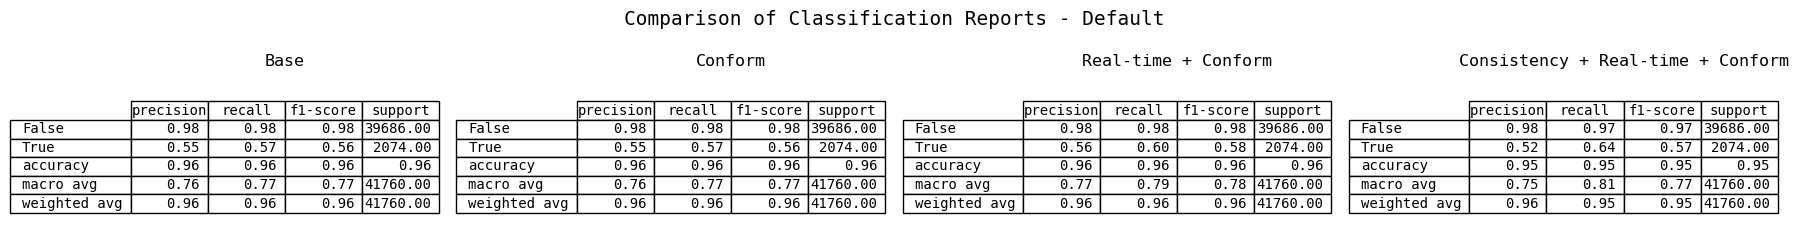

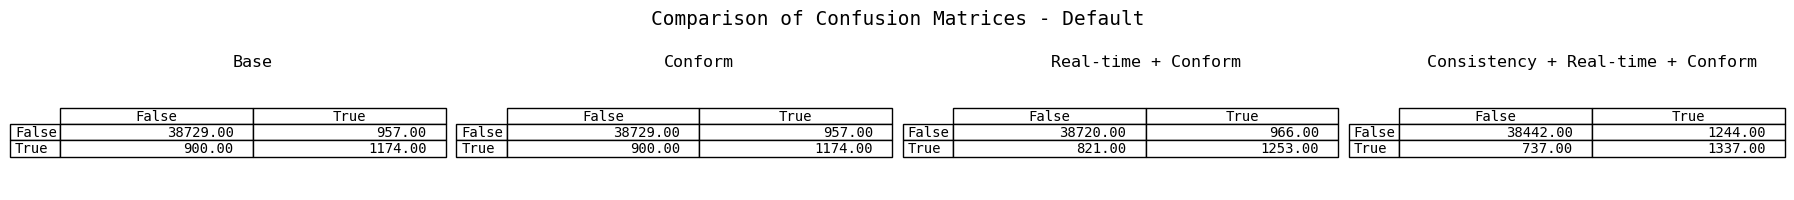

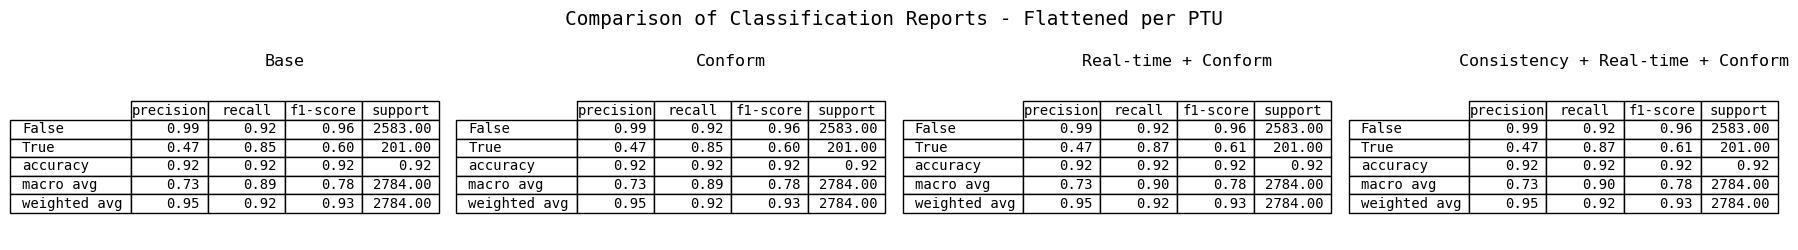

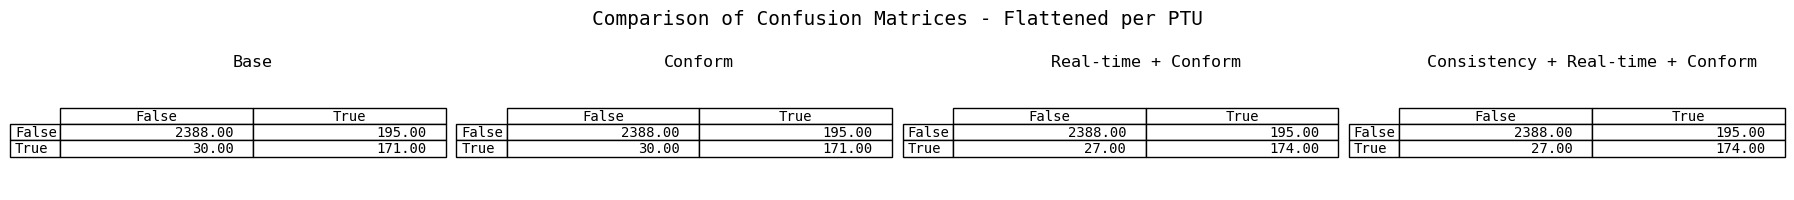

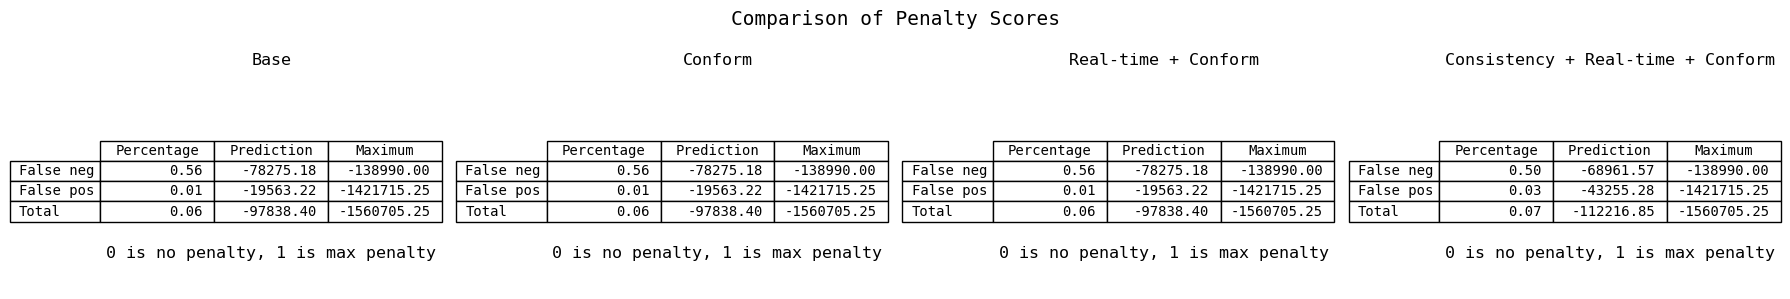

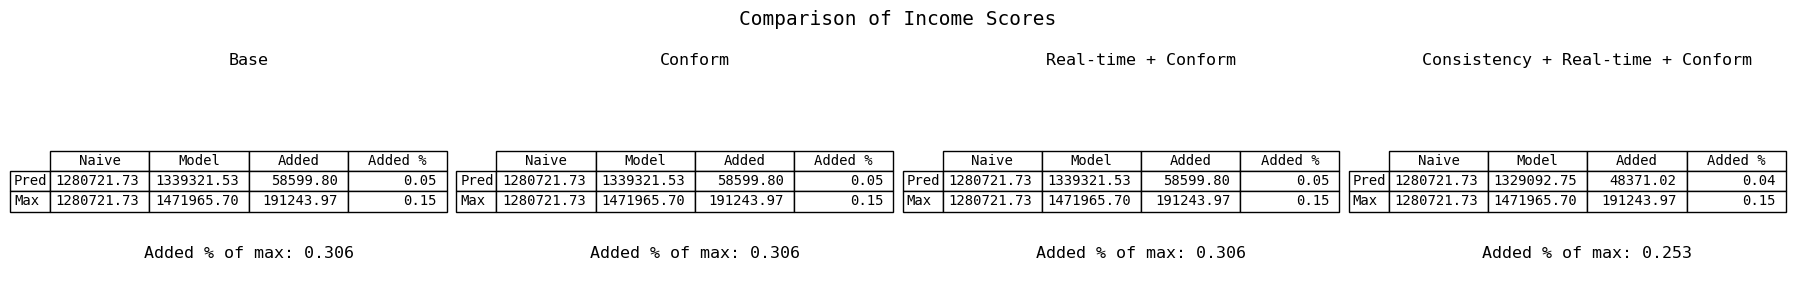

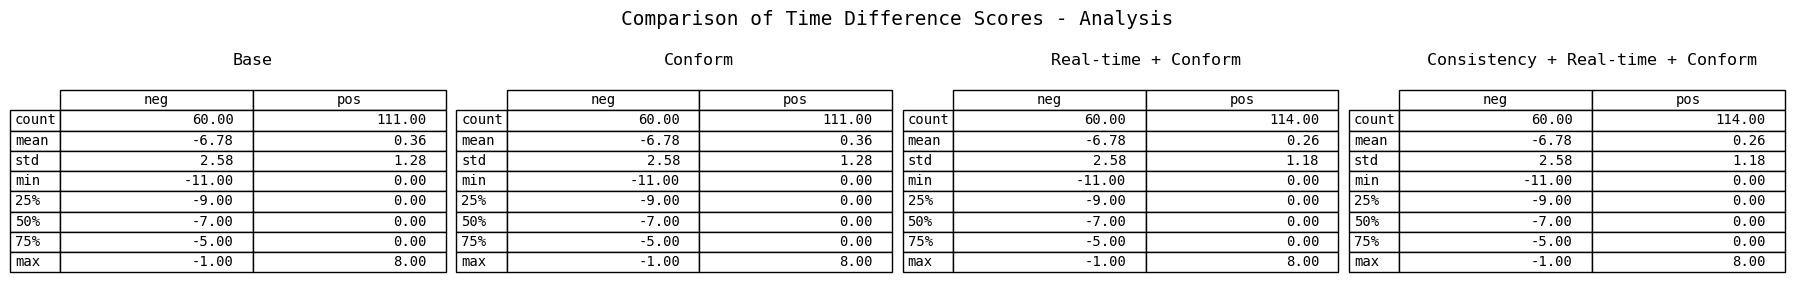

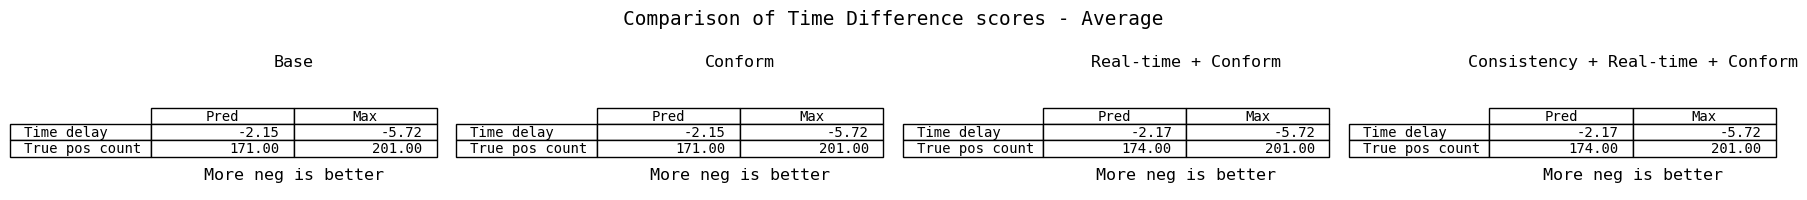

In [10]:
features = [
    "import_capacity",
    "min_price_published",
    "mid_price_published",
    "max_price_published",
    "min_ptu_price_known",
    "max_ptu_price_known",
    "fix_min_ptu_price_known",
    "fix_max_ptu_price_known",
    "fix_settlement_price_bestguess_alt",
    "settlement_price_bestguess_alt",
    "time_since_last_two_sided",
    "time_since_last_two_sided_alt",
    "two_sided_daily_count",
    "PTU",
    "minute_in_ptu",
    "naive_strategy_action",
    "vwap_avg",
    "vwap_std",
    "vwap_median",
    "vwap_qty_sum",
    "hvq_delta",
    "fix_two_sided_ptu_realtime",
    "residual_load",
    "dispatch_diff",
    "igcc_diff",
    "is_balanced",
    "weekday",
    "workday",
    "month",
    "down_price_volume",
    "up_price_volume",
    "last_15min_up_volume",
    "last_15min_down_volume",
    "downward_dispatch_published_peak",
    "downward_dispatch_published_peak_time",
    "downward_dispatch_published_peak_diff",
    "igcc_contribution_down_published_peak",
    "igcc_contribution_down_published_peak_time",
    "igcc_contribution_down_published_peak_diff",
    "min_price_published_1",
    "max_price_published_1",
    "fix_two_sided_ptu_17",
    "settlement_price_realized_17",
    "minute_in_ptu_2"
]

print("Number of used features:", len(features))
splits = get_splits(df, features, target, return_dict_pair=False)



def train(train_in, train_out):
    model = HistGradientBoostingRegressor(loss="poisson", l2_regularization=8, learning_rate=0.05, validation_fraction=0.5, categorical_features="from_dtype")
    model = model.fit(train_in, train_out)
    return model


def test(model, test_in):
    pred = model.predict(test_in)
    return recast_pred(pred > 0.5), pred

mask = splits[train_set][3]["started_down"]

t = np.ones(len(mask), dtype=bool)
t[:15 * 2] = False
mask = mask & t


X_train = splits[train_set][0][mask]
y_train = splits[train_set][1][mask]

best, _ = evaluate_income(train, test, X_train, y_train, splits[test_set][0], splits[test_set][3], repeat=16)

pred, base_pred = test(best[0], splits[test_set][0])
show_metrics_adjusted(splits[test_set][3], pred, version=version)

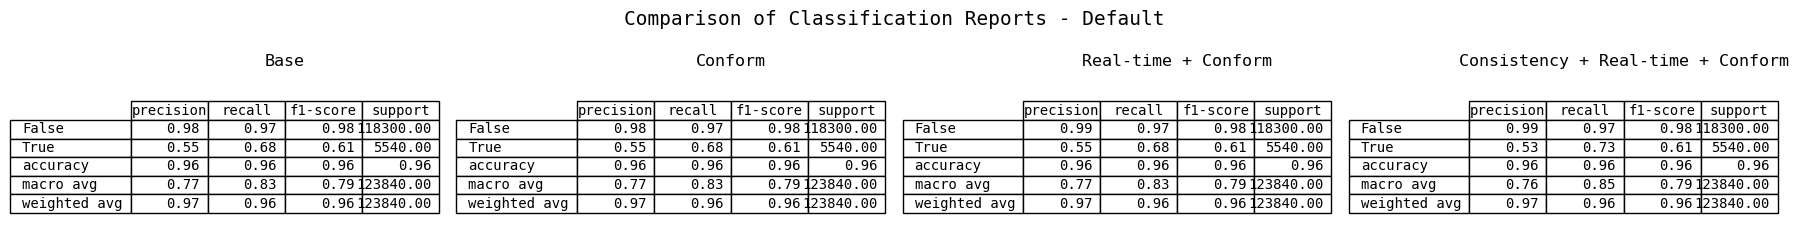

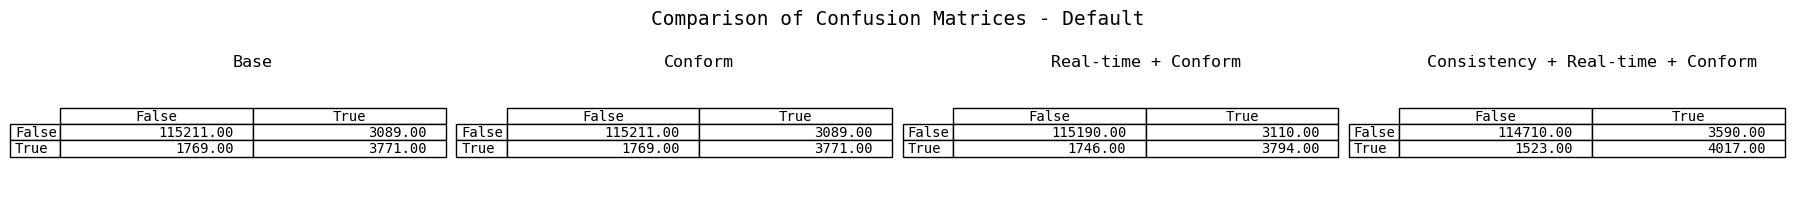

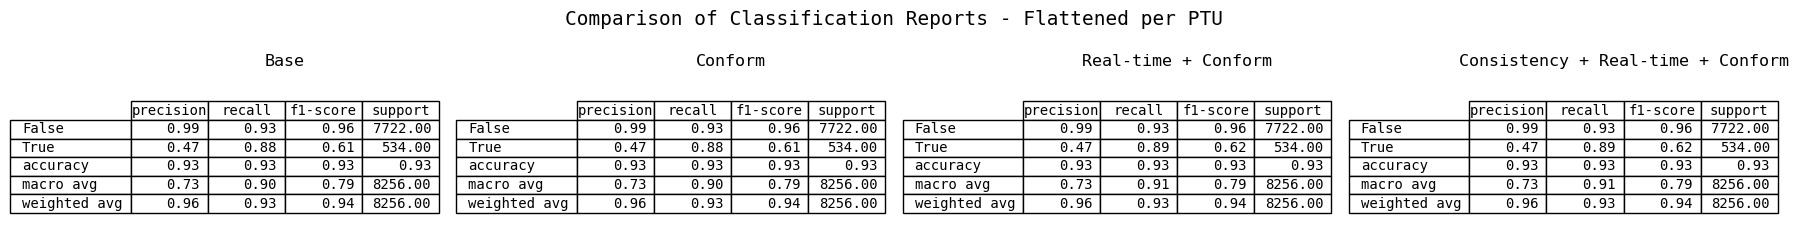

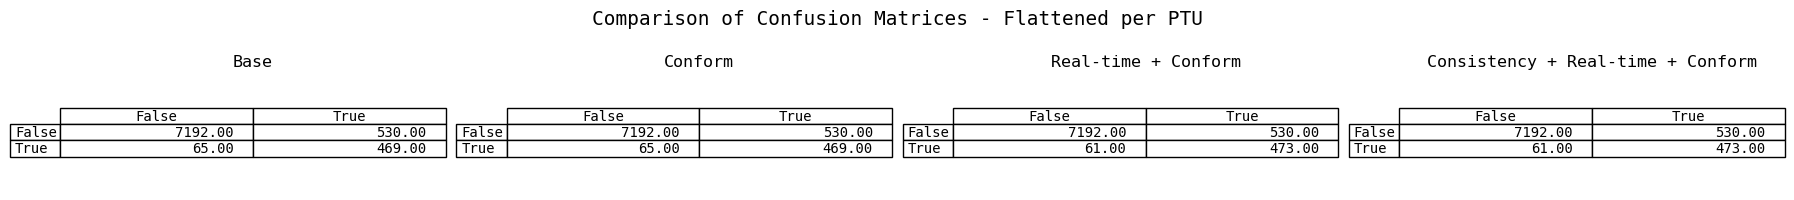

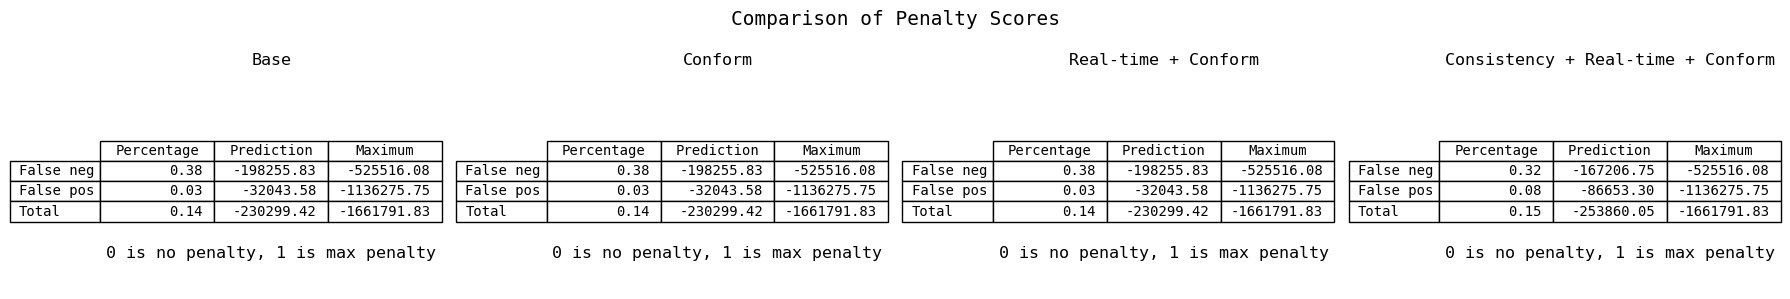

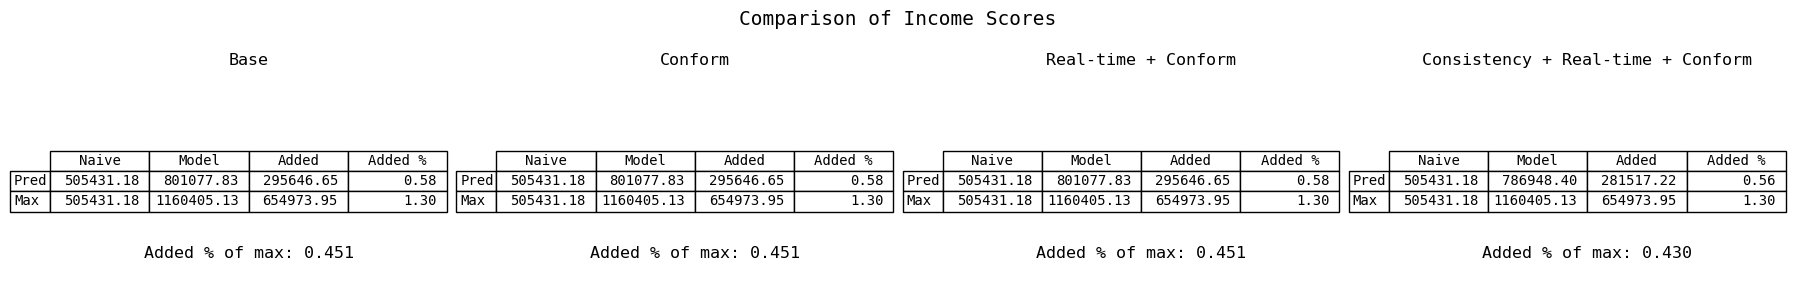

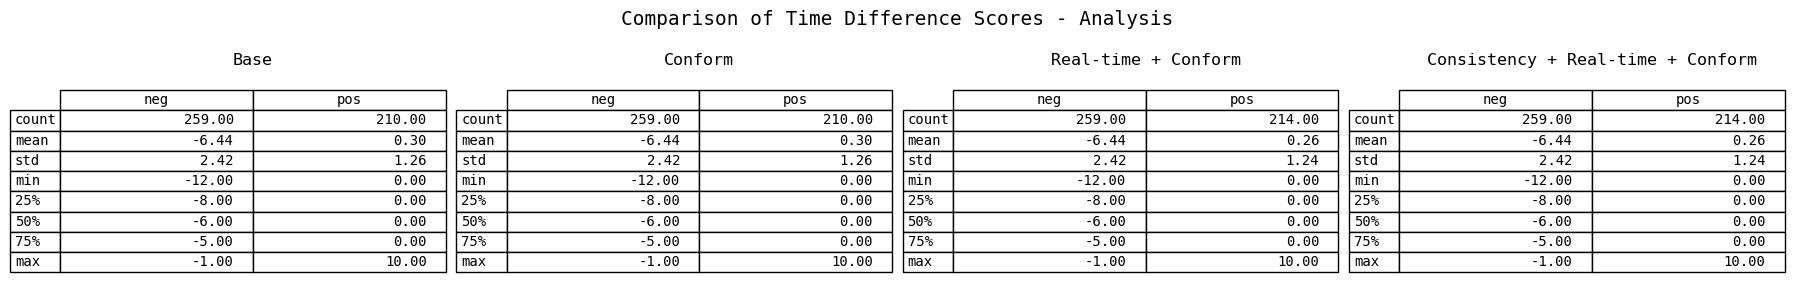

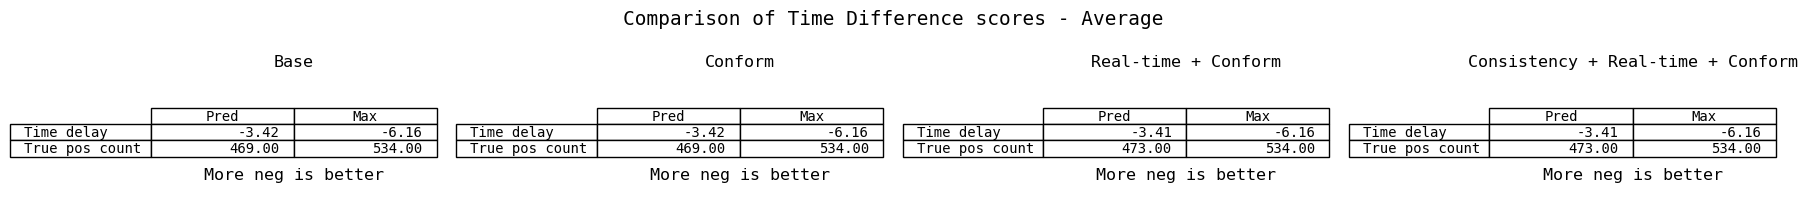

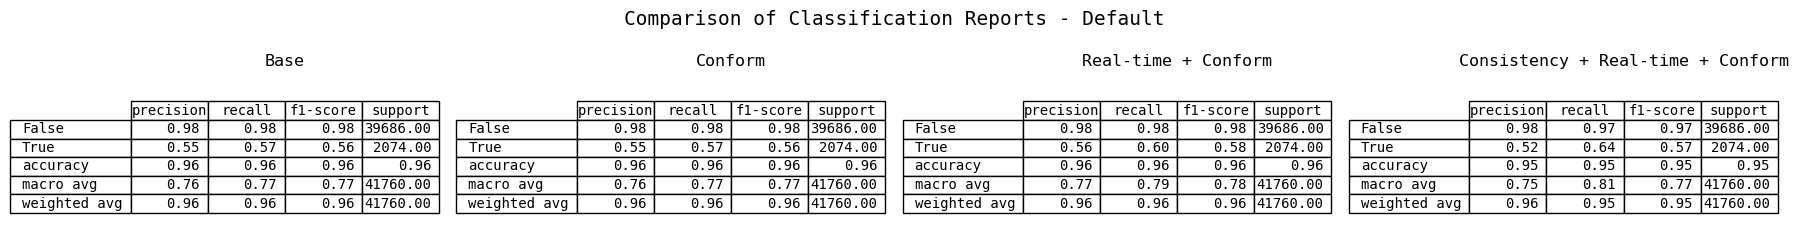

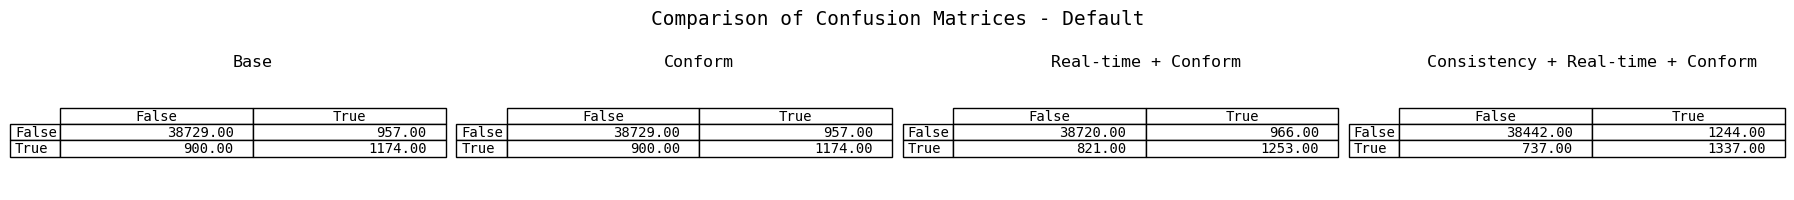

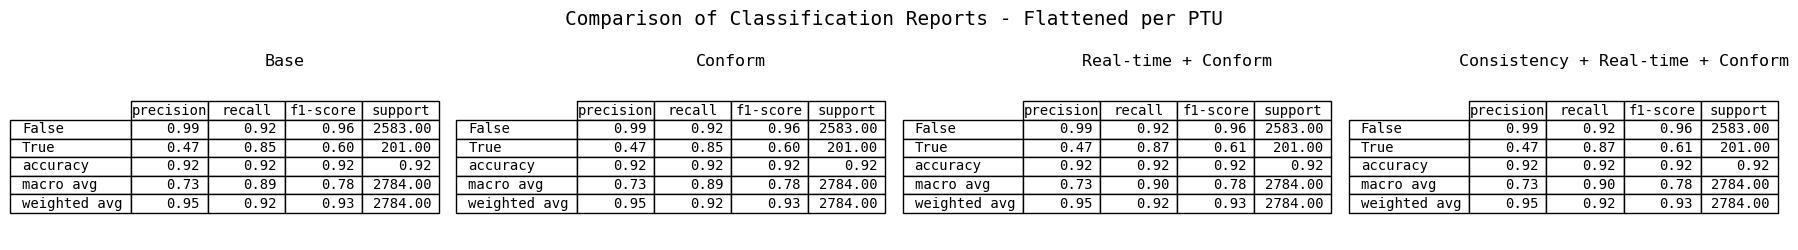

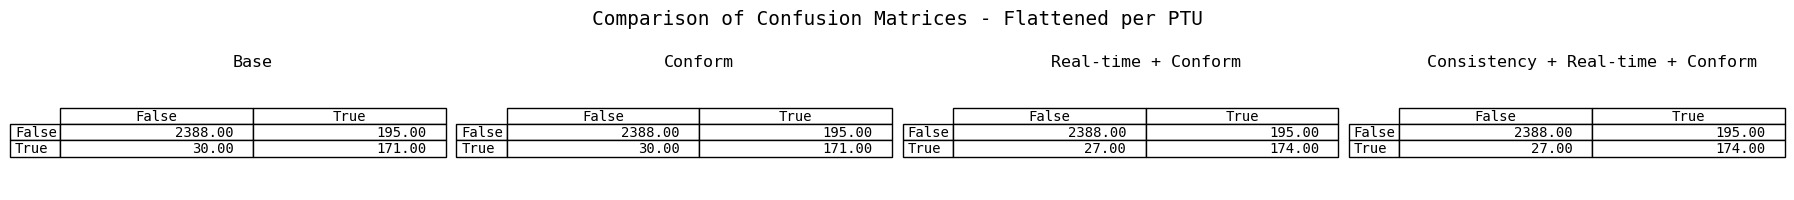

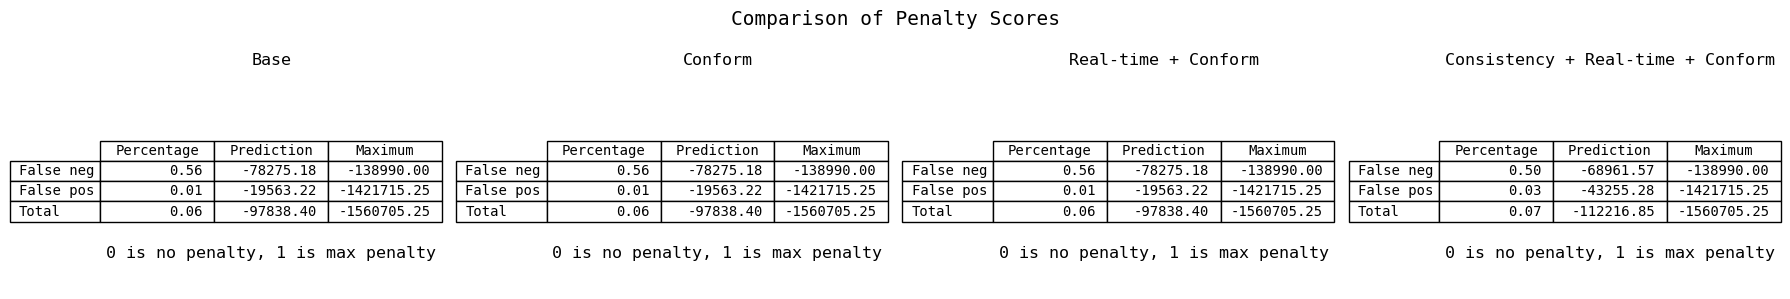

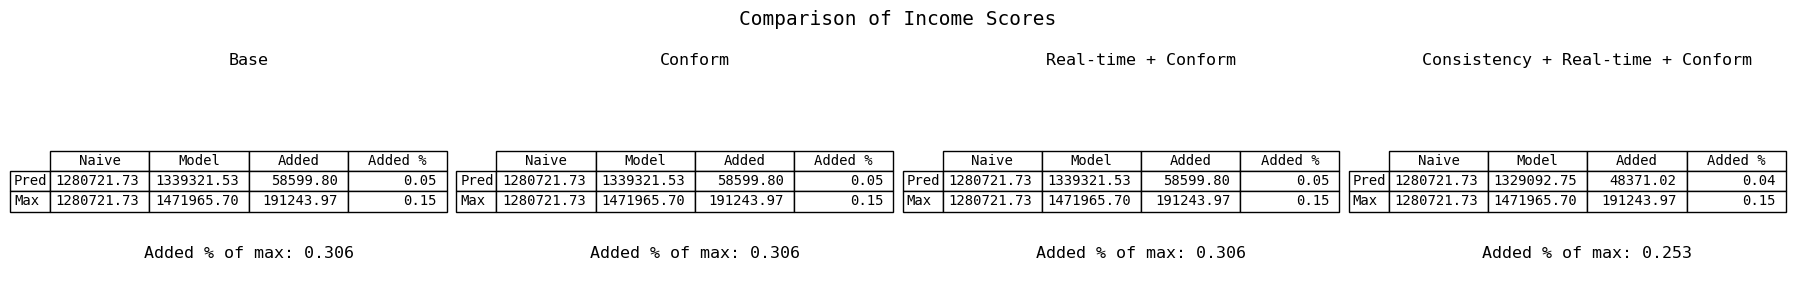

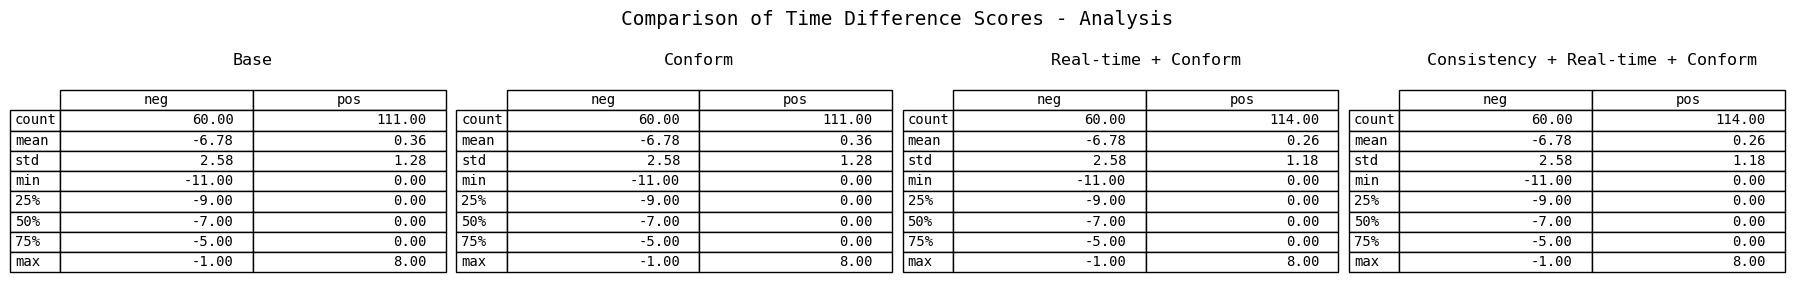

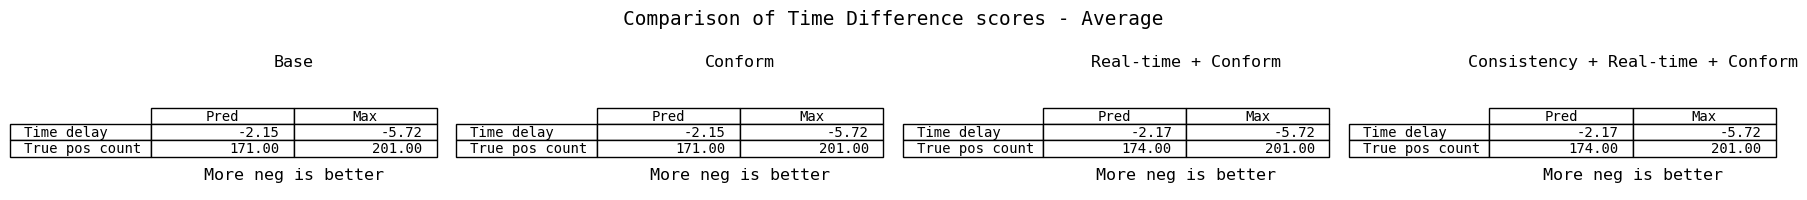

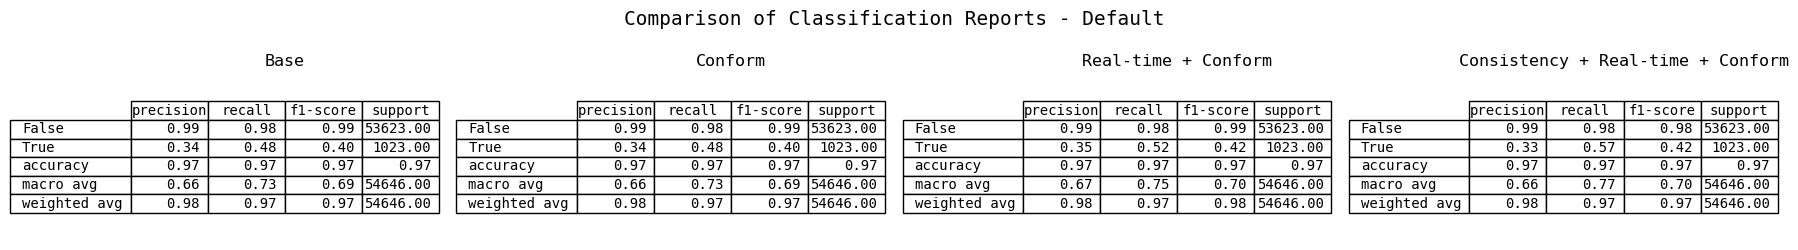

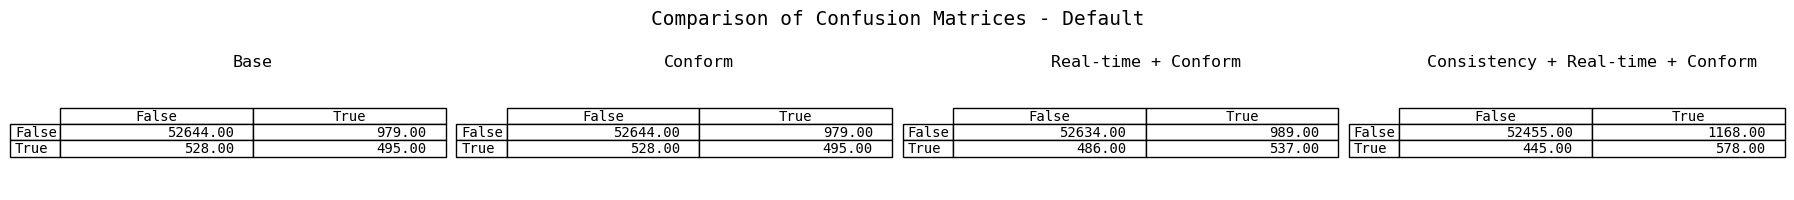

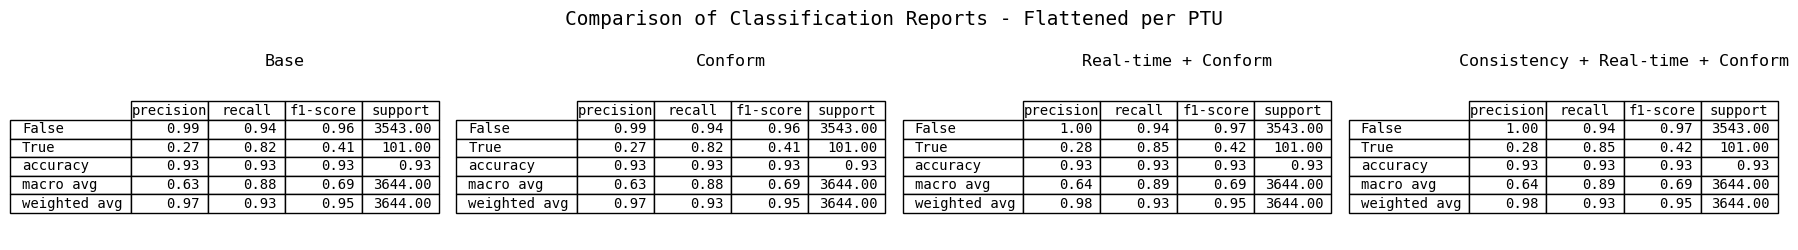

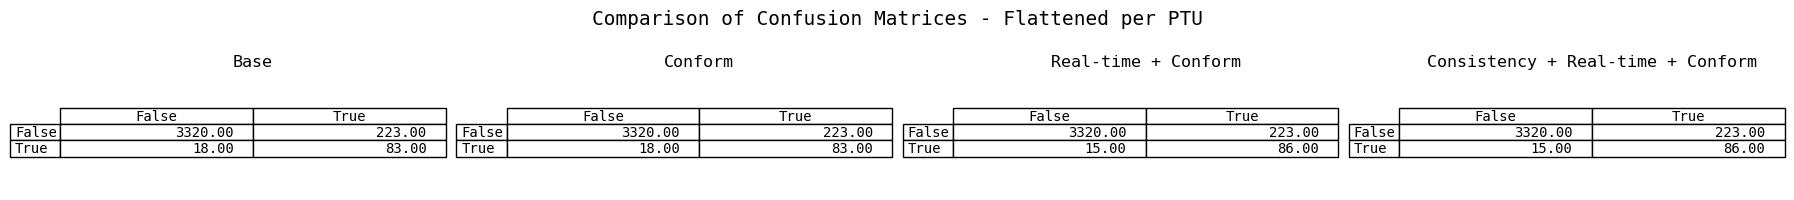

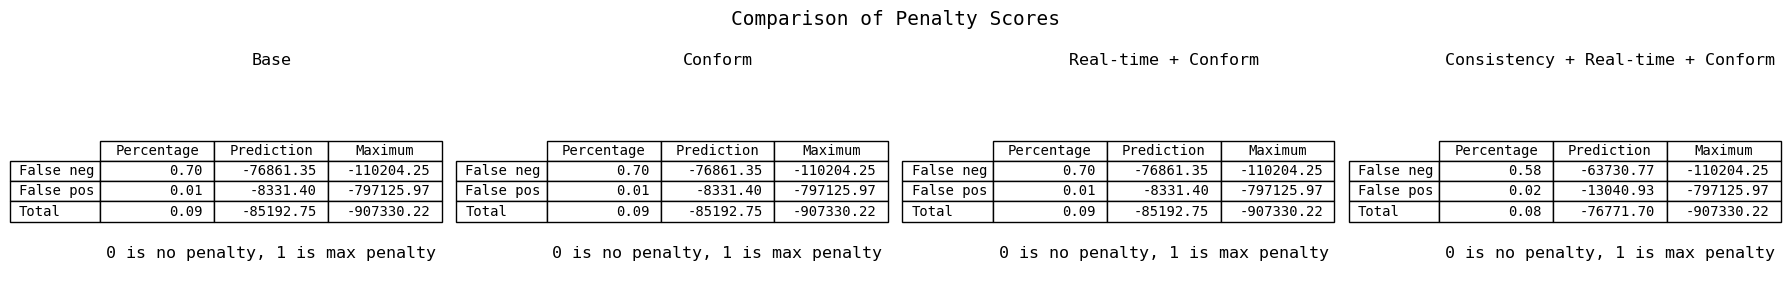

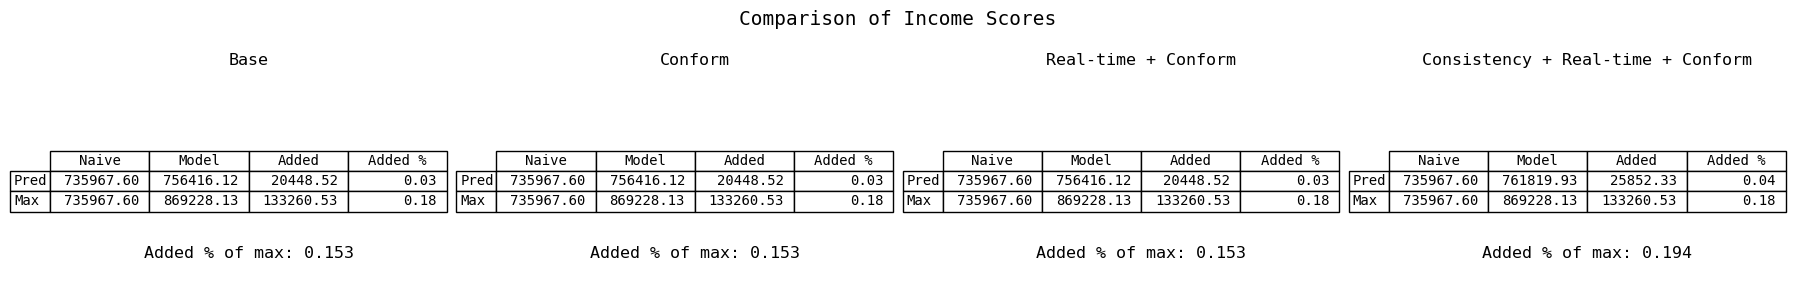

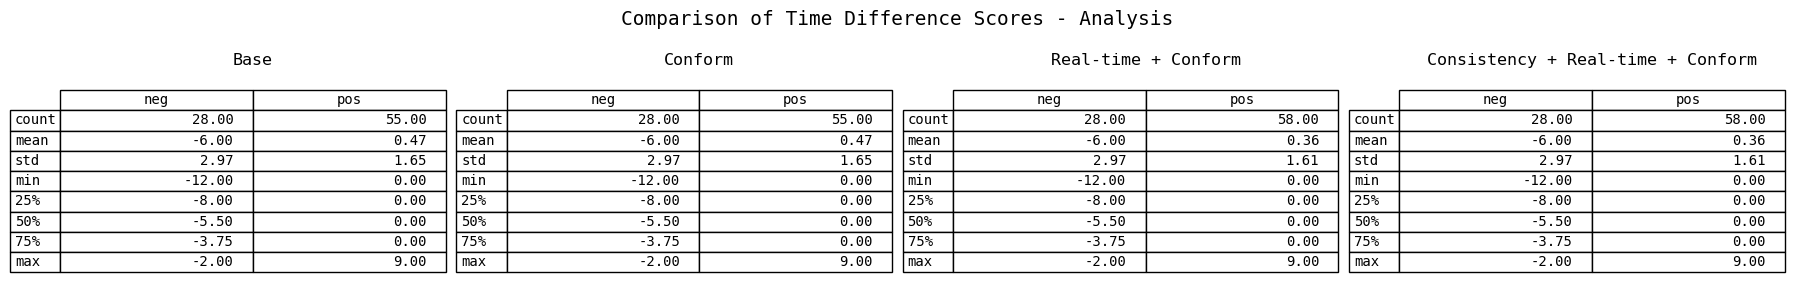

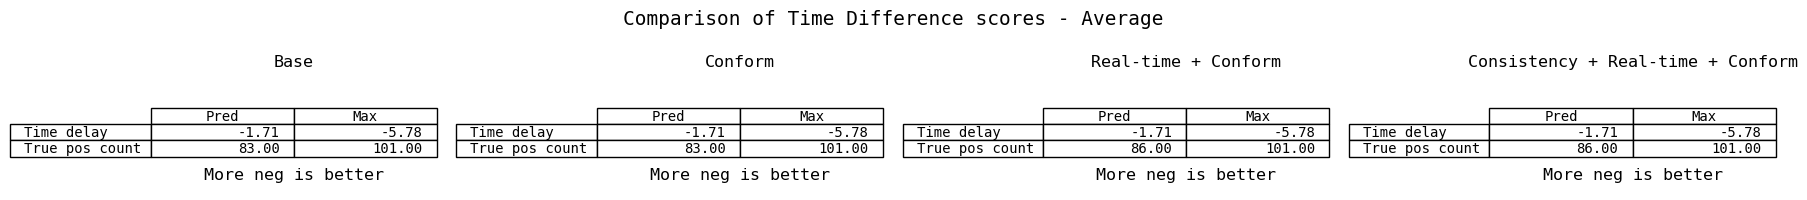

In [11]:
p_tr, _ = test(best[0], splits["train"][0])
show_metrics_adjusted(splits["train"][3], p_tr, version=version)

p_va, _ = test(best[0], splits["valid"][0])
show_metrics_adjusted(splits["valid"][3], p_va, version=version)

p_te, _ = test(best[0], splits["test"][0])
show_metrics_adjusted(splits["test"][3], p_te, version=version)

In [12]:
save_model(best, "hgbr")

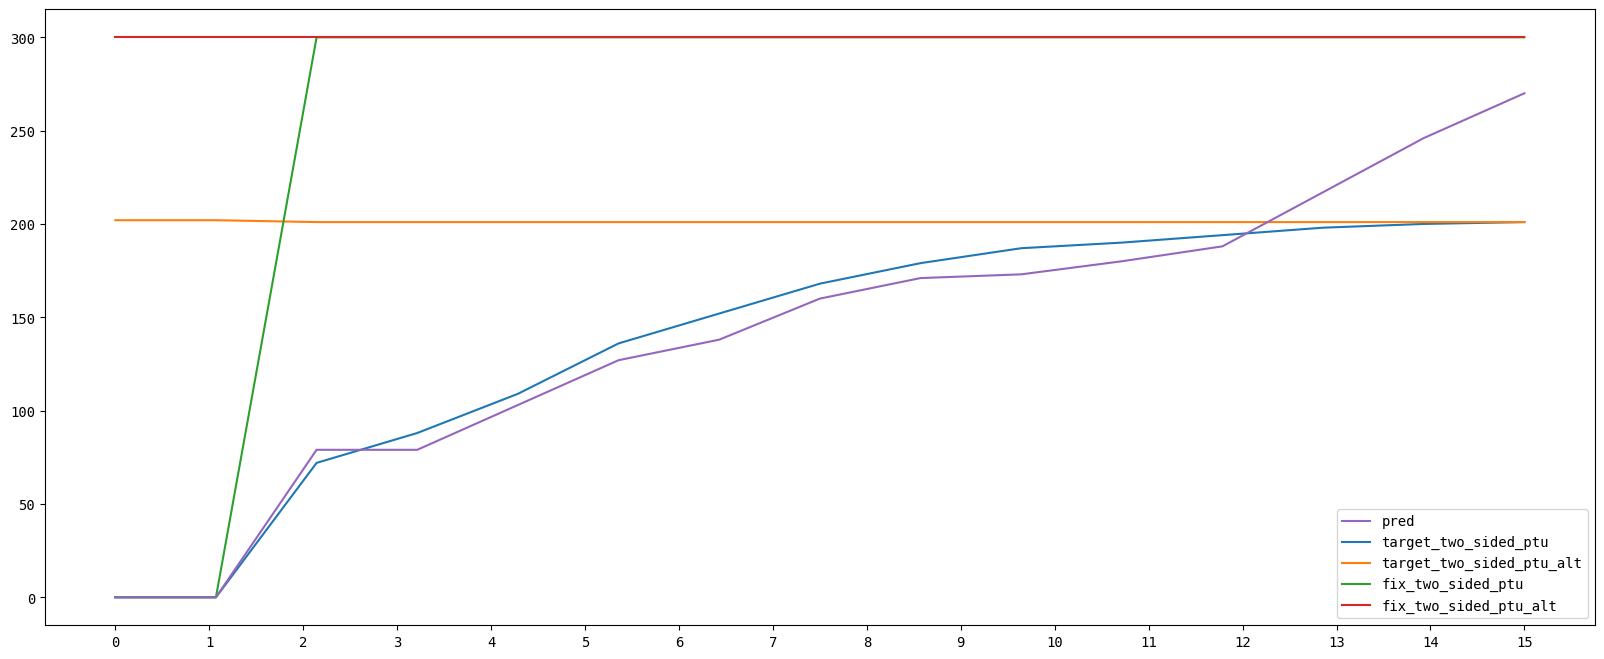

In [13]:
targets = [
    "target_two_sided_ptu",
    "target_two_sided_ptu_alt",
    # "target_two_sided_ptu_realtime",
    "fix_two_sided_ptu",
    "fix_two_sided_ptu_alt",
    # "fix_two_sided_ptu_realtime",
    "pred"
]
agg_dict = {t: "sum" for t in targets}
view = splits[test_set][3]
view["pred"] = pred
items = 15
flat_df = view.groupby("minute_in_ptu").agg(agg_dict)
flat_df.index = np.linspace(0, items, items)

for t in targets:
    plot_against_index(flat_df[t], show=False)
plt.xticks(range(0, items + 1, 1))
show_graph()